# This project is about predicting the temperature 12 hours from now given a set of past features. The data is from Germany for about 7 years at the hourly granularity 

In [1]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.utils import timeseries_dataset_from_array
import numpy as np
from matplotlib import pyplot as plt
import os

# Read the data from the csv file (do not worry); the header gives you the meaning of the features

In [2]:
fname = os.path.join("../datasets/pollution.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

['date', 'pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']


# These lines compute the temperature (the target) and the raw_data (the features). The raw_data also contains the temperature since past temperature will be used to predict the next temperature

In [3]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

# Define the proper number of samples for the training, testing, and validation sets; do not create new sets

In [4]:
num_train_samples = int(len(lines) * 0.8)
num_val_samples = int(len(lines) * 0.1)
num_test_samples = len(lines) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
print("total:",num_train_samples + num_val_samples + num_test_samples)

num_train_samples: 35040
num_val_samples: 4380
num_test_samples: 4380
total: 43800


# Normalize the raw data

In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# This is the utility code to generate the data as discussed in the videos

In [6]:
sequence_length = 120
lookahead = 12 # predict 12 hours in the future
delay = (sequence_length + lookahead - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples-1)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples-1)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=num_train_samples + num_val_samples + num_test_samples-delay-1)


# Now define the DNN model, plot the results;

In [7]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1],))
x = layers.Reshape((sequence_length*raw_data.shape[-1],))(inputs)
x = layers.Dense(16,activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
)


Epoch 1/20
137/137 [==============================] - 4s 20ms/step - loss: 38.5872 - mae: 4.8275 - val_loss: 38.3578 - val_mae: 4.8255
Epoch 2/20
137/137 [==============================] - 2s 13ms/step - loss: 26.2198 - mae: 3.9474 - val_loss: 35.1111 - val_mae: 4.6017
Epoch 3/20
137/137 [==============================] - 2s 15ms/step - loss: 24.3236 - mae: 3.7854 - val_loss: 33.5616 - val_mae: 4.4608
Epoch 4/20
137/137 [==============================] - 2s 15ms/step - loss: 23.2255 - mae: 3.6856 - val_loss: 32.3912 - val_mae: 4.3532
Epoch 5/20
137/137 [==============================] - 2s 16ms/step - loss: 22.3839 - mae: 3.6143 - val_loss: 31.4889 - val_mae: 4.2783
Epoch 6/20
137/137 [==============================] - 2s 17ms/step - loss: 21.6959 - mae: 3.5530 - val_loss: 30.8648 - val_mae: 4.2223
Epoch 7/20
137/137 [==============================] - 2s 15ms/step - loss: 21.1371 - mae: 3.5008 - val_loss: 30.2908 - val_mae: 4.1708
Epoch 8/20
137/137 [==============================] - 2

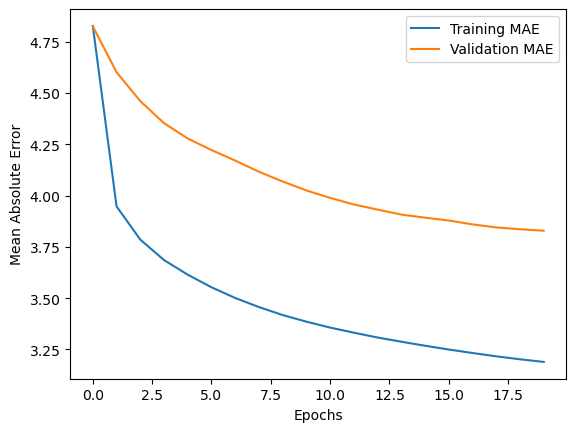

In [8]:
# Plot training results
import matplotlib.pyplot as plt

plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


17/17 [==============================] - 0s 11ms/step - loss: 15.8867 - mae: 2.9773
Test Loss: 15.8867, Test MAE: 2.9773
17/17 [==============================] - 0s 10ms/step


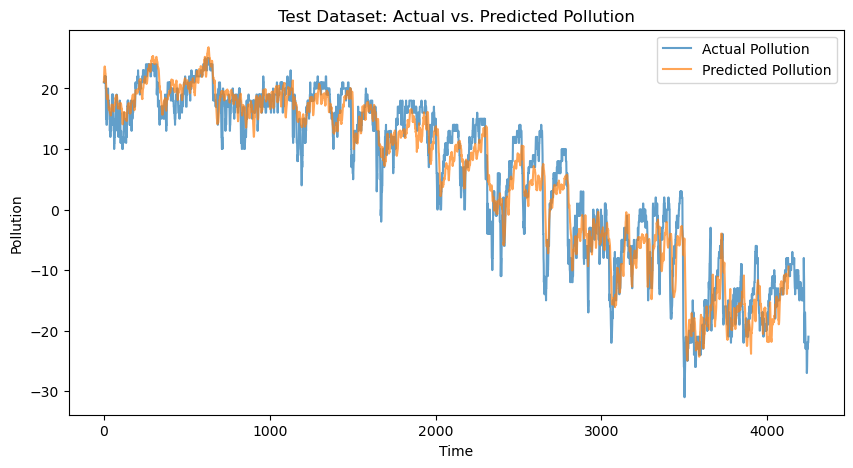

In [11]:
# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Generate predictions for the test dataset
predictions = model.predict(test_dataset)

# Plot actual vs. predicted temperature values
import matplotlib.pyplot as plt

actual_temperatures = temperature[num_train_samples + num_val_samples + delay : num_train_samples + num_val_samples + num_test_samples]

plt.figure(figsize=(10, 5))
plt.plot(actual_temperatures, label="Actual Pollution", alpha=0.7)
plt.plot(predictions, label="Predicted Pollution", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Pollution")
plt.legend()
plt.title("Test Dataset: Actual vs. Predicted Pollution")
plt.show()